### Comparing .dat file and .csv file trials
- parsing of same timestamp's .dat and .csv file should give you same data

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import mab_subjects
from banditpy.io import dat2ArmIO, csv2ArmIO
from BanditAnalysisFunctions import sessdf_unstr, sessdf_str

folder = Path("D:/Data/mab/BGdataset")
dat_task = dat2ArmIO(folder)
csv_task = csv2ArmIO(folder)
dat2_task = sessdf_unstr("bgf1", folder, 83)

### Auto block id creation
- check if auto block id creation is working fine.

In [ ]:
import mab_subjects
import numpy as np
import pandas as pd

exps = mab_subjects.unstruc.allsess + mab_subjects.struc.allsess

for exp in exps:
    print(exp.sub_name)
    task = exp.b2a.filter_by_trials(min_trials=100, clip_max=100)
    task.auto_block_window_ids()
    mask = task.block_ids == 1
    task = task._filtered(mask)

### Are all sessions good ?
- While plotting some example figures, I noticed sometimes the animals perform poorly ---choosing only one port--- in a set of successive sessions. This could have been caused by hardware malfunctioning.
- The code below calculates the number of switches in each session and plots the histogram of number of sessions with number of switches

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from neuropy import plotting
import seaborn as sns
import mab_subjects
from statplotannot.plots import fix_legend

exps = mab_subjects.unstruc.allsess + mab_subjects.struc.allsess
# exps = mab_subjects.mostly_unstruc.allsess + mab_subjects.mostly_struc.allsess

swp_df = []

fig = plotting.Fig(4, 3, fontsize=10)

for e, exp in enumerate(exps):
    print(exp.sub_name)
    task = exp.b2a.filter_by_trials(min_trials=100, clip_max=100)
    trials_per_session = task.ntrials_session
    choices_chunks = np.split(task.choices, np.cumsum(trials_per_session))[:-1]

    n_switches = np.array([np.sum(np.diff(choices) != 0) for choices in choices_chunks])

    bins = np.arange(0, 30, 1)
    hist_switches, edges = np.histogram(n_switches, bins=bins)

    df = pd.DataFrame(
        {
            "n_switches": bins[:-1],
            "density": hist_switches / np.sum(hist_switches),
            "name": exp.sub_name,
            "grp": exp.group_tag,
            "lesion": exp.lesion_tag,
            "dataset": exp.data_tag,
        }
    )
    swp_df.append(df)

swp_df = pd.concat(swp_df, ignore_index=True)
mab_subjects.GroupData().save(swp_df, "switch_density")

In [ ]:
import matplotlib.pyplot as plt
from neuropy import plotting
import seaborn as sns
import mab_subjects
from statplotannot.plots import fix_legend
import mab_colors

df = mab_subjects.GroupData().switch_density.latest
df = df[df["lesion"] == "pre_lesion"]

fig = plotting.Fig(3, 3, fontsize=12)

ax = fig.subplot(fig.gs[0, 0])

sns.lineplot(
    data=swp_df,
    ax=ax,
    x="n_switches",
    y="density",
    hue="grp",
    hue_order=["unstruc", "struc"],
    palette=mab_colors.colors_2arm(),
    errorbar="se",
)
fix_legend(ax)

### Check reward probability alignment with set reward for chosen port
- It is possible that because of code/hardware bug the set reward wasn't what the animal experienced. The code below checks reward_alignment between programmed and emperical reward. The correlation coefficient should ideally be above 0.95, anything below may indicate some issue with the code/opcon box.

BGM0
BGF1
BGF2
BGF3
BGM5
BGM1
BGF0
BGM3
BGM4
BGF4


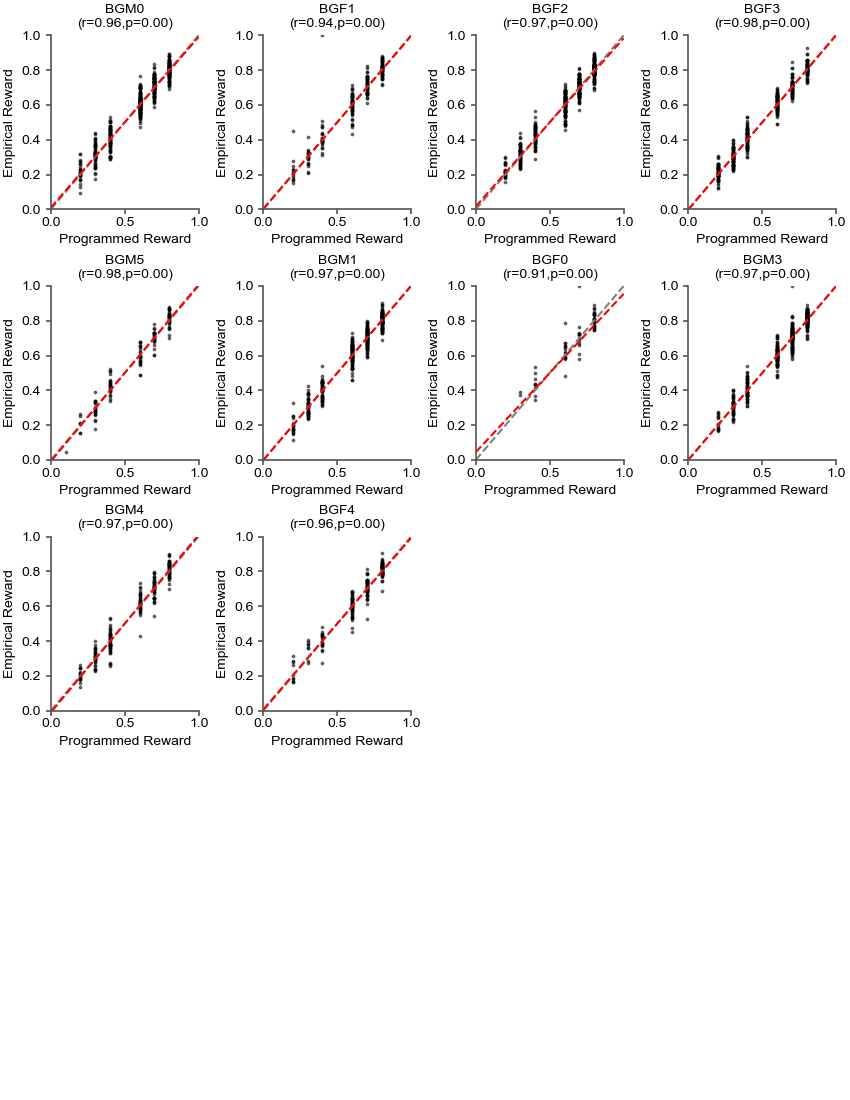

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import mab_subjects
from neuropy import plotting
from scipy import stats


# exps = mab_subjects.unstruc.allsess + mab_subjects.struc.allsess
exps = mab_subjects.mostly_unstruc.allsess + mab_subjects.mostly_struc.allsess

fig = plotting.Fig(5, 4, fontsize=10)


for e, exp in enumerate(exps):
    print(exp.sub_name)

    align_df = exp.b2a.filter_by_trials(100, 100).compare_reward_alignment()
    x = align_df["prog_rew"].values
    y = align_df["emp_rew"].values
    linfit = stats.linregress(x, y)

    ax = fig.subplot(fig.gs[e])
    ax.scatter(x, y, alpha=0.5, s=3, c="k")
    ax.axline((0.5, 0.5), slope=1, color="gray", linestyle="--")
    ax.axline((0.5, 0.5), slope=linfit.slope, color="red", linestyle="--")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(f"{exp.sub_name}\n(r={linfit.rvalue:.2f},p={linfit.pvalue:.2f})")
    ax.set_xlabel("Programmed Reward")
    ax.set_ylabel("Empirical Reward")